Notebook on learning R, \gamma and p simultaneously using Environment Design


In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

from src.utils.inference.sampling import bayesian_parameter_learning
from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)
from src.utils.visualization import (
    plot_posterior_distribution,
    plot_environment,
    plot_trajectories,
    mcmc_diagnostics,
    plot_log_likelihood,
)
from src.utils.constants import ParamTuple, beta_agent
from src.utils.optimization import soft_q_iteration
from src.utils.inference.rollouts import generate_n_trajectories

np.set_printoptions(linewidth=160, precision=2)

Create Environment


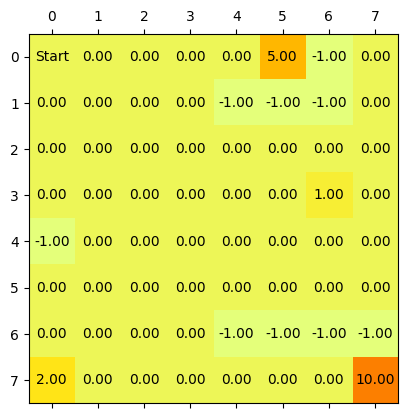

In [3]:
# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 15
n_posterior_samples = 10
n_traj_per_sample = 2

## 0.2 Setup the environment
N, M = 8, 8
n_states, n_actions = N * M, 4

# TODO describe world
agent_R = np.zeros((N, M))
agent_R[0, M - 3] = 5
agent_R[3, M - 2] = 1
agent_R[N - 1, 0] = 2
agent_R[N - 1, M - 1] = 10
agent_R[4, 0] = -1

agent_R[1, M - 4] = -1
agent_R[1, M - 3] = -1
agent_R[1, M - 2] = -1
agent_R[0, M - 2] = -1

agent_R[N - 2, M - 4] = -1
agent_R[N - 2, M - 3] = -1
agent_R[N - 2, M - 2] = -1
agent_R[N - 2, M - 1] = -1

plot_environment(agent_R.reshape(N, M), [])

# Start by making the agent we want to learn the policy of
agent_p = 0.9
agent_gamma = 0.8
p_true = 0.999

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)

n_samples_MC = 5_000
n_burnin_MC = 2_500

# Prior Sampling


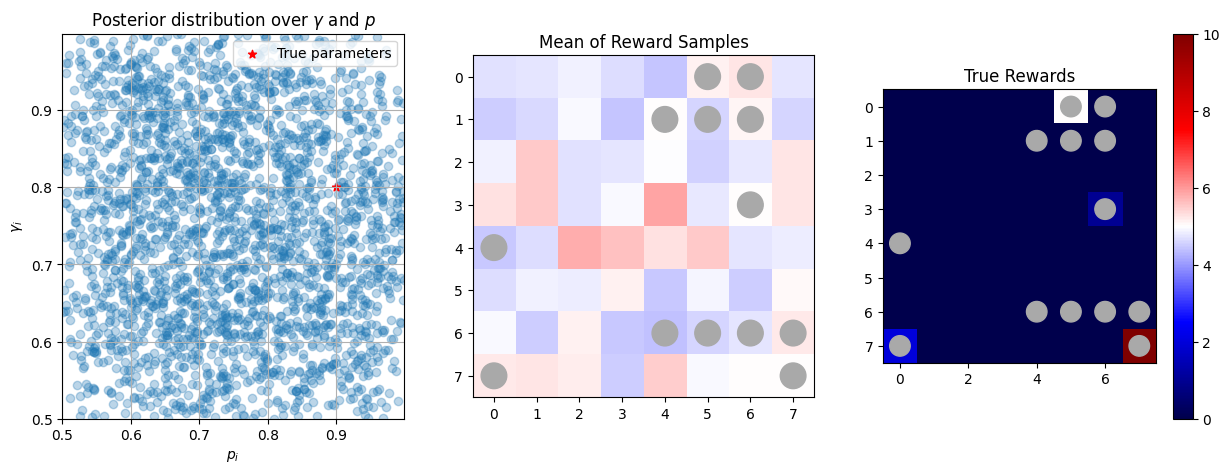

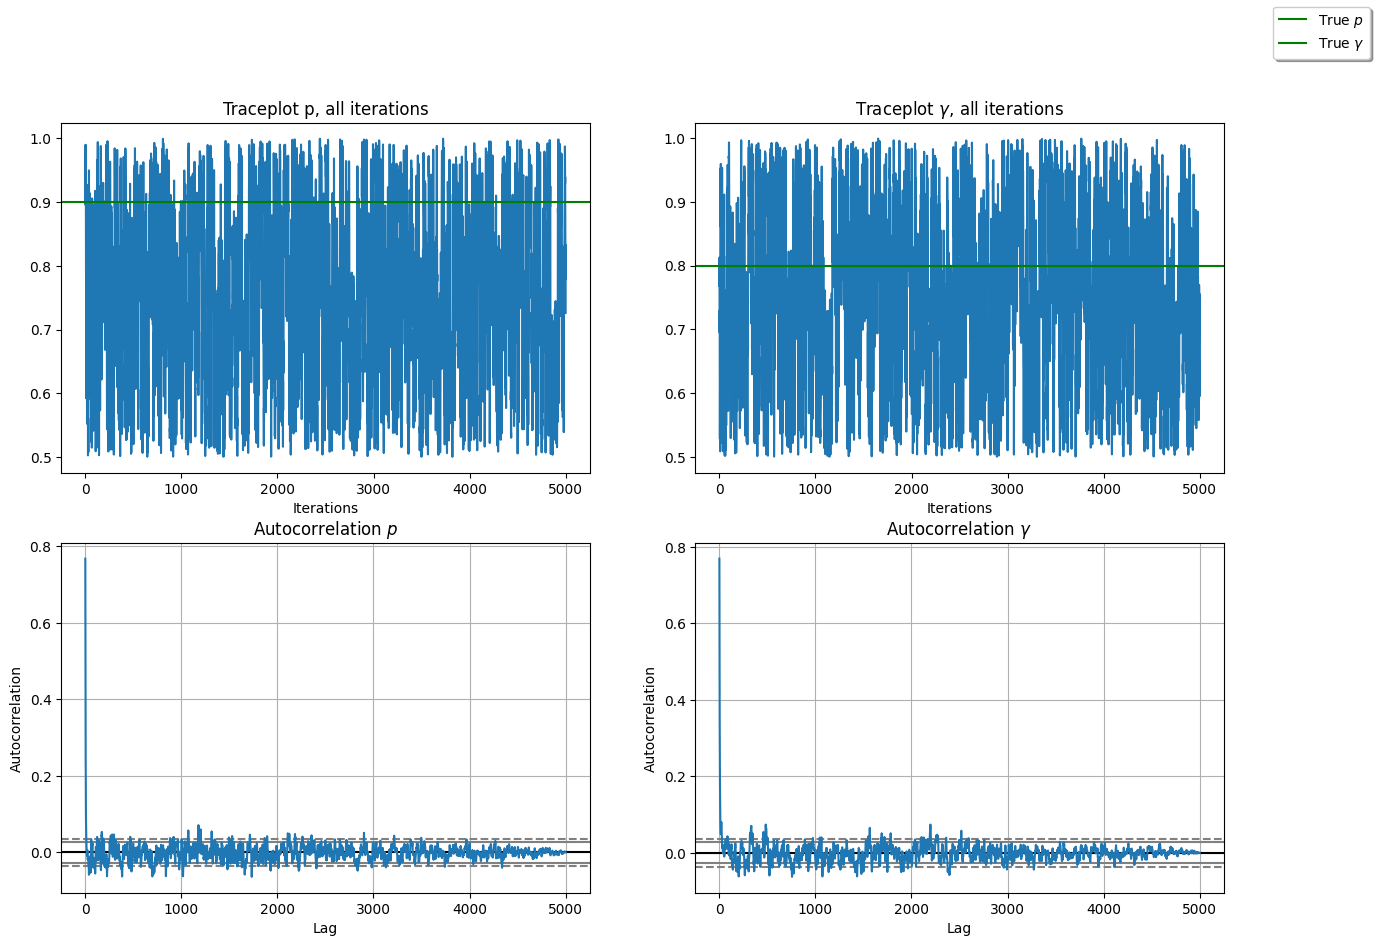

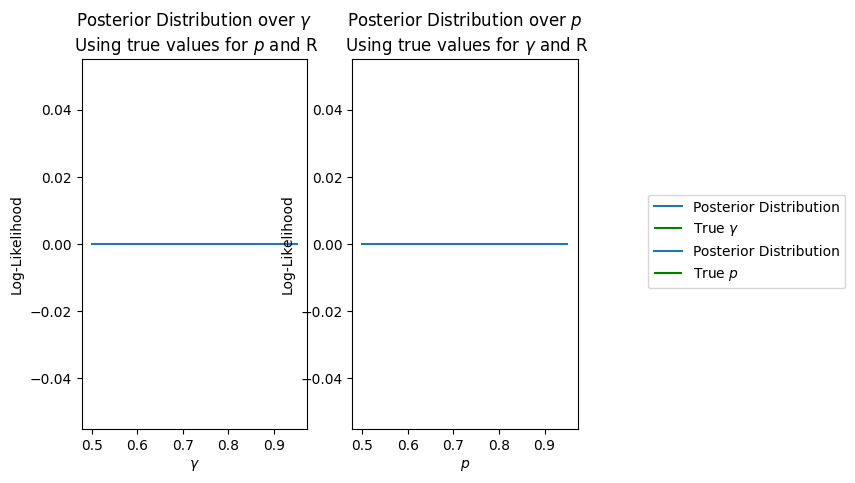

In [4]:
posterior_samples_0 = bayesian_parameter_learning(
    expert_trajectories=[],
    sample_size=n_samples_MC,
    goal_states=goal_states,
    n_states=n_states,
)

plot_posterior_distribution(
    posterior_samples=posterior_samples_0[n_burnin_MC:],
    N=N,
    M=M,
    absorbing_states=goal_states,
    true_params=true_params,
)

mcmc_diagnostics(posterior_samples_0, true_params=true_params)

plot_log_likelihood(
    param_values=true_params, expert_trajectories=[], goal_states=goal_states
)

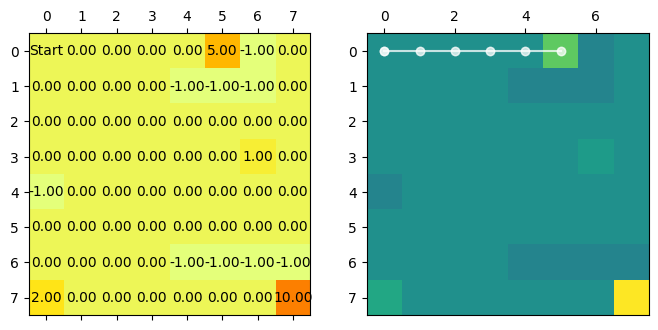

In [5]:
# Generate 2 trajectories in the env starting environment
wall_states = []
T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=100)

env_agent = Environment(
    N=N,
    M=M,
    T_true=T_true,
    wall_states=wall_states,
    R_sample_mean=None,
    start_state=0,
    n_walls=None,
)

# Generate trajectories
trajectories = generate_n_trajectories(
    T_agent,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

expert_trajectories_1 = [(env_agent, trajectories)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

## After Iteration 1


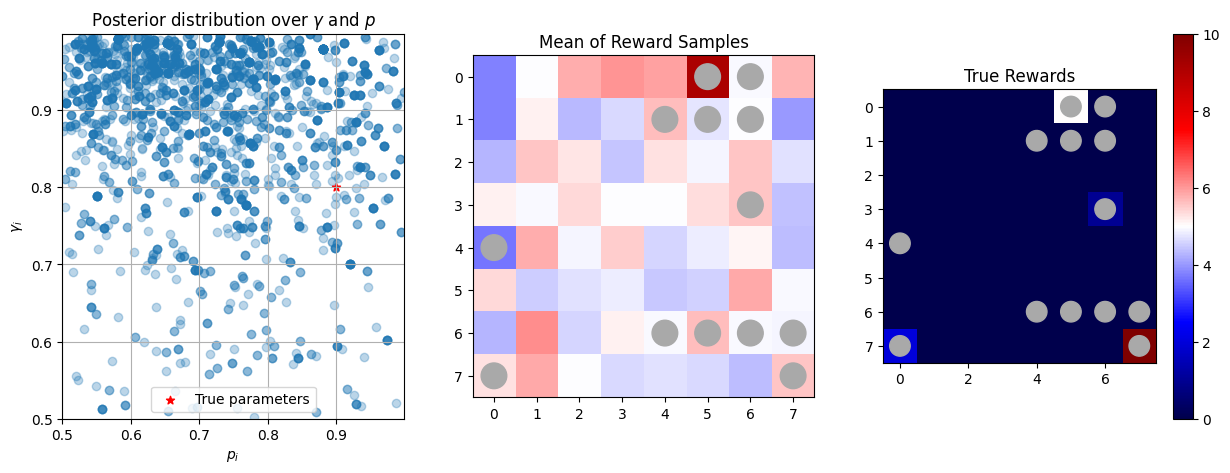

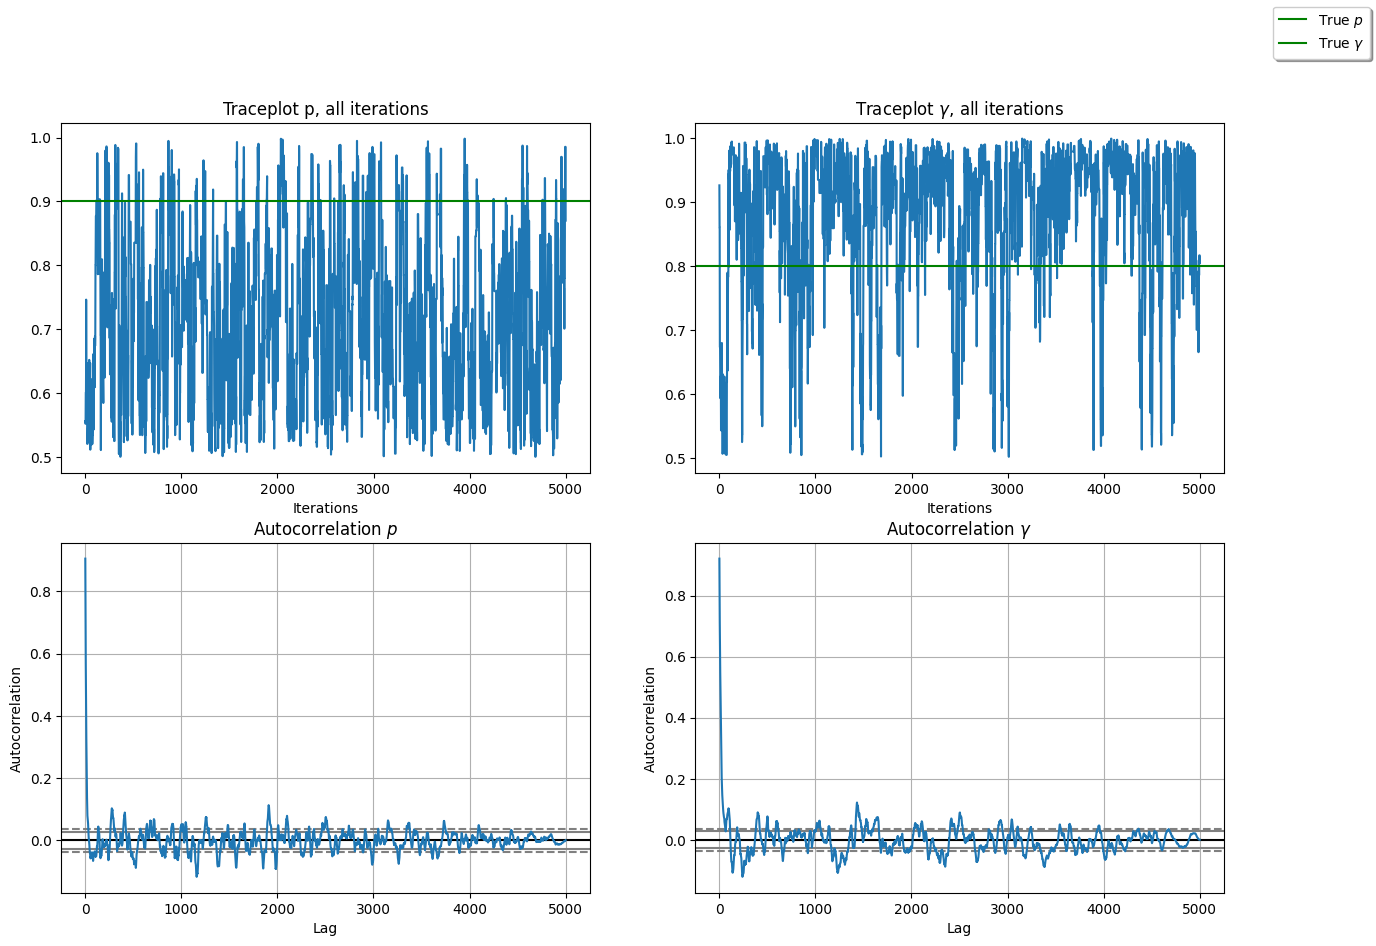

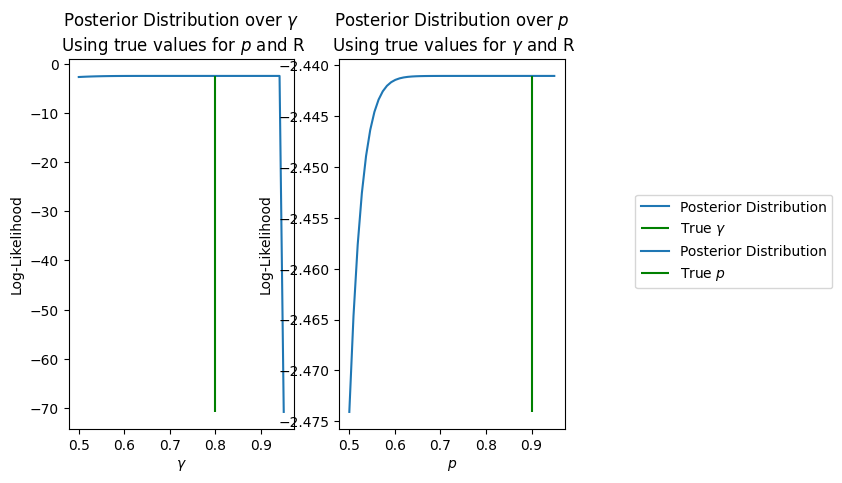

In [6]:
posterior_samples_1 = bayesian_parameter_learning(
    expert_trajectories=expert_trajectories_1,
    sample_size=n_samples_MC,
    goal_states=goal_states,
    n_states=n_states,
)

plot_posterior_distribution(
    posterior_samples=posterior_samples_1[n_burnin_MC:],
    N=N,
    M=M,
    absorbing_states=goal_states,
    true_params=true_params,
)

mcmc_diagnostics(posterior_samples_1, true_params=true_params)

plot_log_likelihood(
    param_values=true_params,
    expert_trajectories=expert_trajectories_1,
    goal_states=goal_states,
)

#### Create the unknown true agent and trajectories in the chosen environment


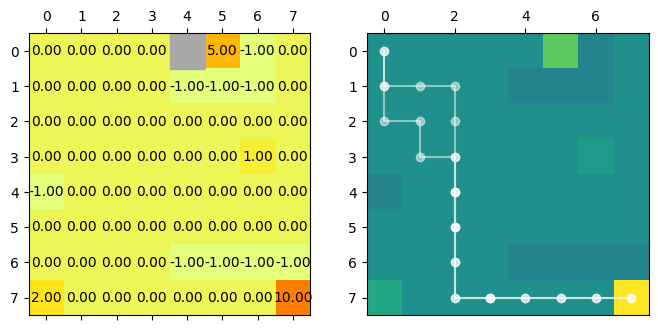

In [7]:
# Generate 2 trajectories in the second round environment
wall_states = [4]

"""
hard code, wall states are absorbing
"""
# goal_states = np.append(goal_states, wall_states)
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=wall_states)
T_true_iteration_2 = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)

"""this is new, we need to add the walls in the environment
#when we do the rollout, otherwise expert behavior makes no sense"""
# T_true_iteration_2 = insert_walls_into_T(T_true_iteration_2, wall_indices=wall_states)


agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=100)

env_agent_2 = Environment(
    N=N,
    M=M,
    T_true=T_true_iteration_2,
    wall_states=wall_states,
    R_sample_mean=None,
    start_state=0,
    n_walls=None,
)

# Generate trajectories
trajectories_2 = generate_n_trajectories(
    T_agent,
    agent_policy,
    goal_states,
    n_trajectories=2,
)
# expert_trajectories = [(env_agent_2, trajectories_2)]
expert_trajectories_2 = expert_trajectories_1
expert_trajectories_2.append([env_agent_2, trajectories_2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent_2.wall_states,
    start_state=(0),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories_2, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

#### Sample from the posterior under these trajectories


Posterior sampling:  18%|█▊        | 889/5000 [01:17<07:28,  9.16it/s, Acceptance rate=14.6, step_size=0.1]

encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (4, 1, 5)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (4, 1, 5)


Posterior sampling:  18%|█▊        | 891/5000 [01:20<26:54,  2.55it/s, Acceptance rate=14.7, step_size=0.1]

encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (62, 1, 63)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (62, 1, 63)


Posterior sampling:  28%|██▊       | 1387/5000 [02:21<05:13, 11.54it/s, Acceptance rate=10.9, step_size=0.1]

encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (4, 1, 5)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (4, 1, 5)


Posterior sampling:  41%|████▏     | 2068/5000 [04:00<08:36,  5.67it/s, Acceptance rate=8.6, step_size=0.1] 

encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (4, 1, 5)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (4, 1, 5)


Posterior sampling:  65%|██████▍   | 3231/5000 [06:31<11:02,  2.67it/s, Acceptance rate=7.9, step_size=0.1]

encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (62, 1, 63)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (62, 1, 63)


Posterior sampling:  99%|█████████▉| 4938/5000 [10:40<00:21,  2.84it/s, Acceptance rate=6.7, step_size=0.1]

encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (62, 1, 63)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (62, 1, 63)


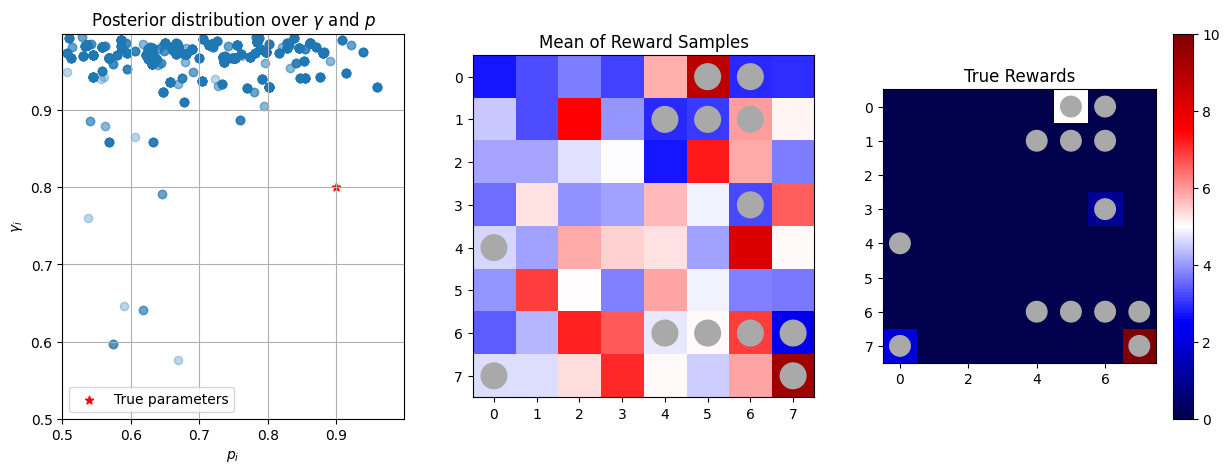

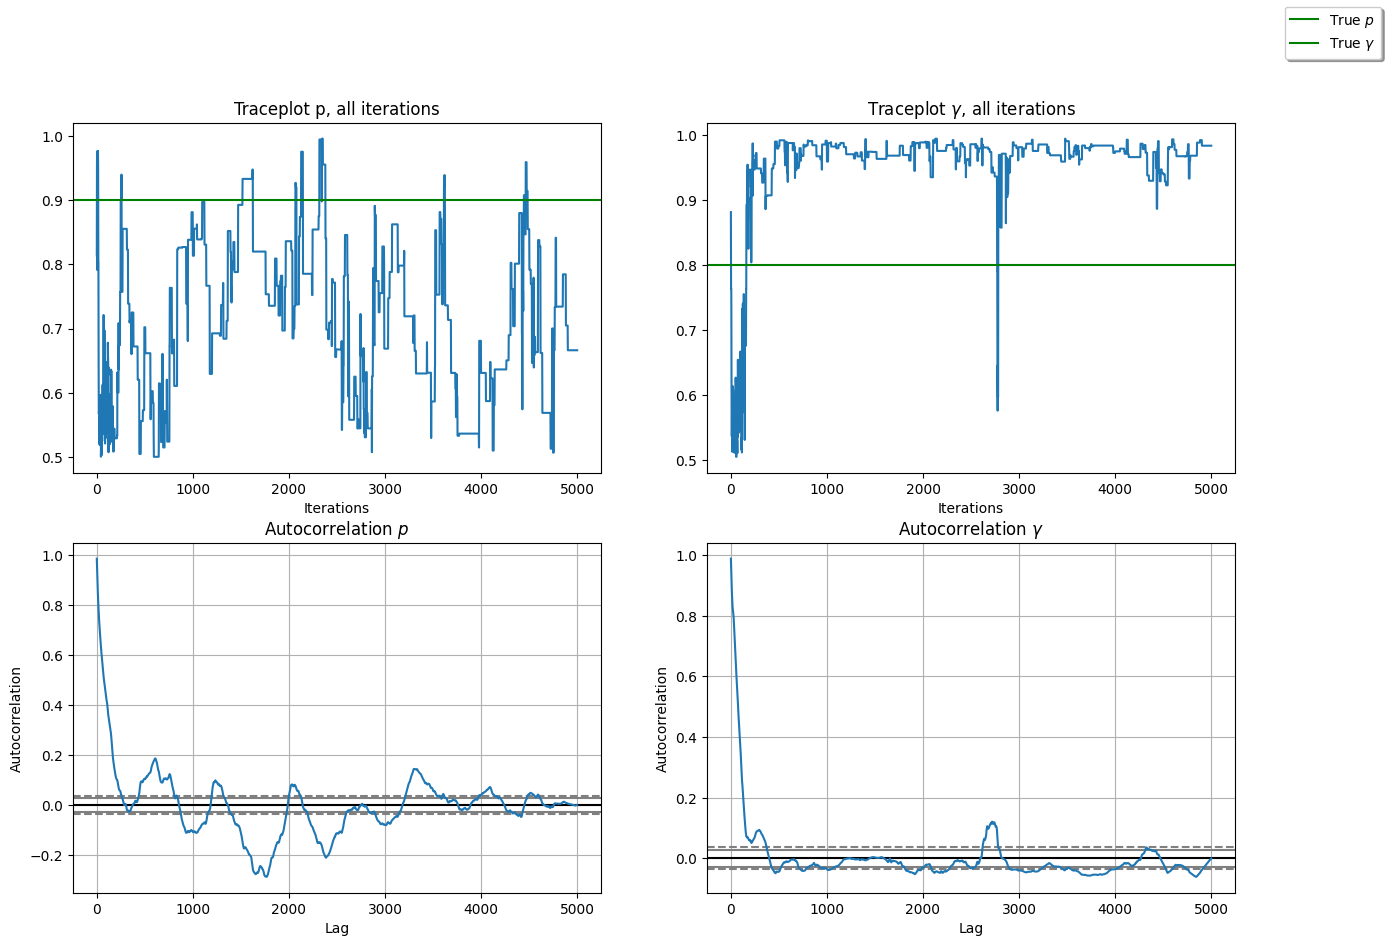

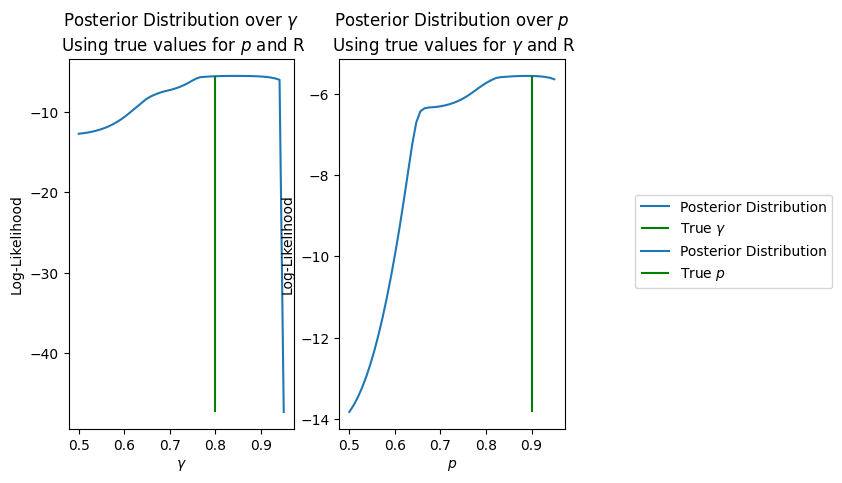

In [8]:
posterior_samples_2 = bayesian_parameter_learning(
    expert_trajectories=expert_trajectories_2,
    sample_size=n_samples_MC,
    goal_states=goal_states,
    n_states=n_states,
)

plot_posterior_distribution(
    posterior_samples=posterior_samples_2[n_burnin_MC:],
    N=N,
    M=M,
    absorbing_states=goal_states,
    true_params=true_params,
)

mcmc_diagnostics(posterior_samples_2, true_params=true_params)

plot_log_likelihood(
    param_values=true_params,
    expert_trajectories=expert_trajectories_2,
    goal_states=goal_states,
)

#### Start round two, maximize regret with the new posterior


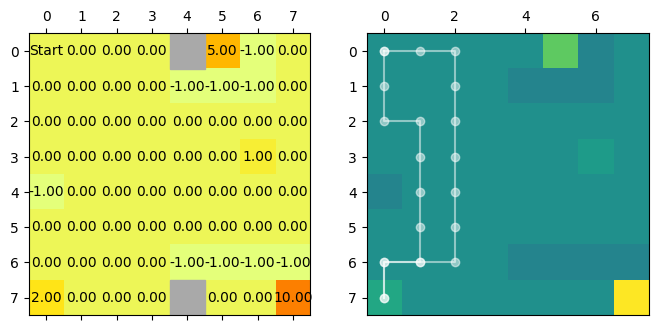

In [9]:
# Generate 2 trajectories in the second round environment
wall_states = [4, (N - 1) * M + 4]
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=wall_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=20.0)

env_agent_3 = Environment(
    N=N,
    M=M,
    T_true=T_true,
    wall_states=wall_states,
    R_sample_mean=None,
    start_state=0,
    n_walls=None,
)

# Generate trajectories
trajectories_3 = generate_n_trajectories(
    T_agent,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

expert_trajectories_3 = expert_trajectories_2
expert_trajectories_3.append([env_agent_3, trajectories_3])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent_3.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories_3, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

Posterior sampling:  42%|████▏     | 2088/5000 [01:49<02:10, 22.30it/s, Acceptance rate=0, step_size=0.1]

encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (60, 1, 61)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (60, 1, 61)


Posterior sampling:  45%|████▌     | 2255/5000 [02:00<01:58, 23.19it/s, Acceptance rate=0, step_size=0.1]

encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (60, 1, 61)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (60, 1, 61)


Posterior sampling:  60%|█████▉    | 2988/5000 [02:42<01:10, 28.40it/s, Acceptance rate=0, step_size=0.1]

encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (60, 1, 61)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (60, 1, 61)


Posterior sampling:  75%|███████▍  | 3744/5000 [03:27<01:32, 13.59it/s, Acceptance rate=0, step_size=0.1]

encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (59, 1, 60)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (60, 1, 61)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (59, 1, 59)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (59, 1, 60)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (60, 1, 61)


Posterior sampling:  75%|███████▌  | 3751/5000 [03:33<09:22,  2.22it/s, Acceptance rate=0, step_size=0.1]

encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (25, 2, 33)


Posterior sampling:  91%|█████████▏| 4574/5000 [04:21<00:25, 16.97it/s, Acceptance rate=0, step_size=0.1]

encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (59, 1, 60)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (60, 1, 61)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (59, 1, 59)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (59, 1, 60)
encountered an impossible transition in my trajectory. this can't be. ignoring it for likelihood
current (s,a,next_s) tuple:  (60, 1, 61)


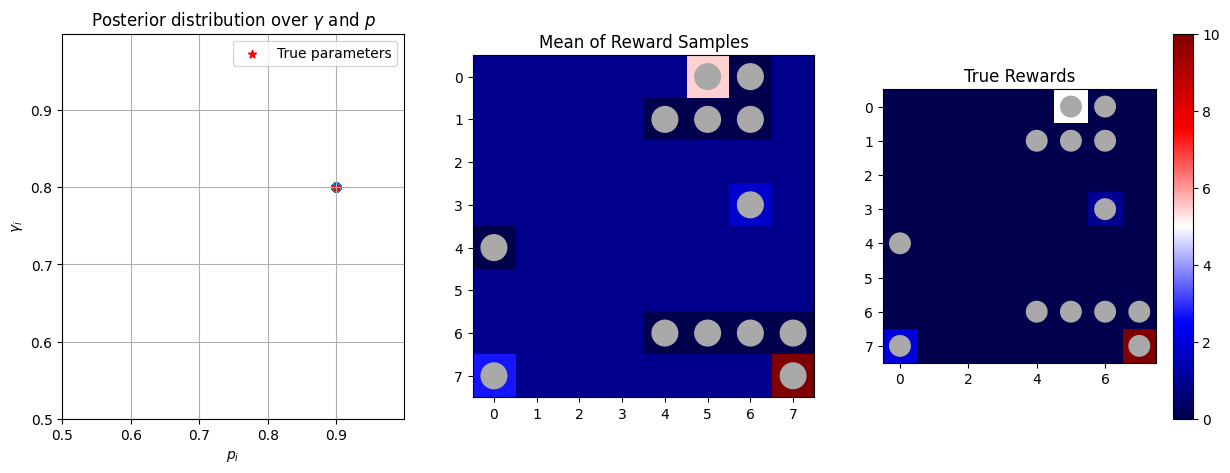

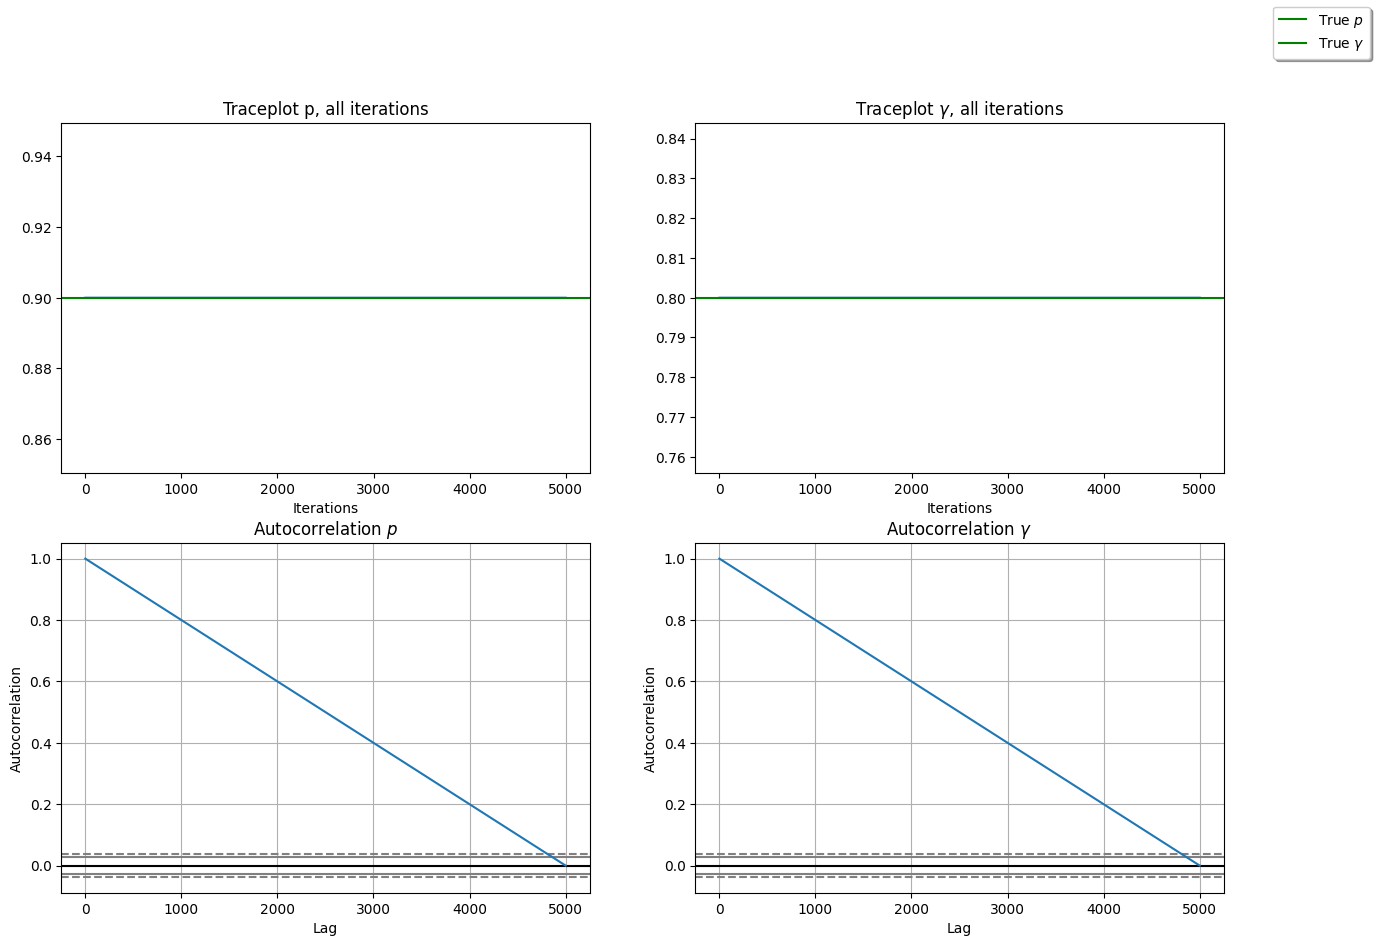

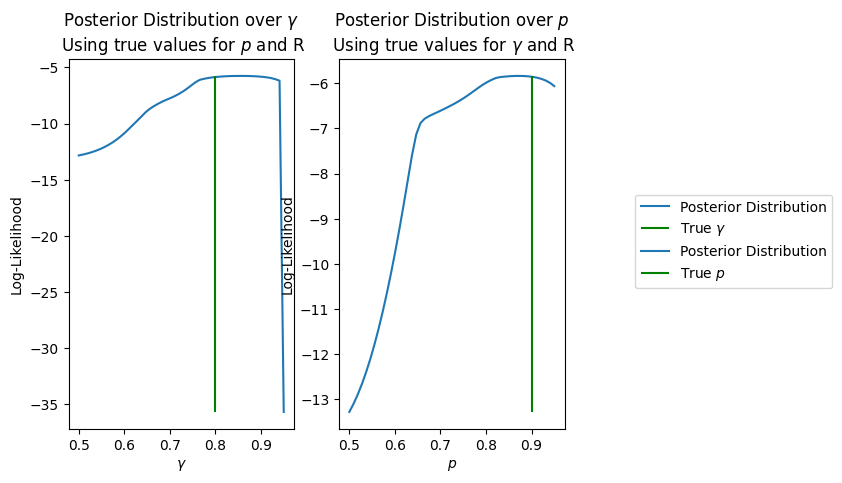

In [10]:
posterior_samples_3 = bayesian_parameter_learning(
    expert_trajectories=expert_trajectories_3,
    sample_size=n_samples_MC,
    goal_states=goal_states,
    n_states=n_states,
    previous_sample=true_params,
)

plot_posterior_distribution(
    posterior_samples=posterior_samples_3[n_burnin_MC:],
    N=N,
    M=M,
    absorbing_states=goal_states,
    true_params=true_params,
)

mcmc_diagnostics(posterior_samples_3, true_params=true_params)

plot_log_likelihood(
    param_values=true_params,
    expert_trajectories=expert_trajectories_3,
    goal_states=goal_states,
)

<Axes: title={'center': 'Autocorrelation $p$'}, xlabel='Lag', ylabel='Autocorrelation'>

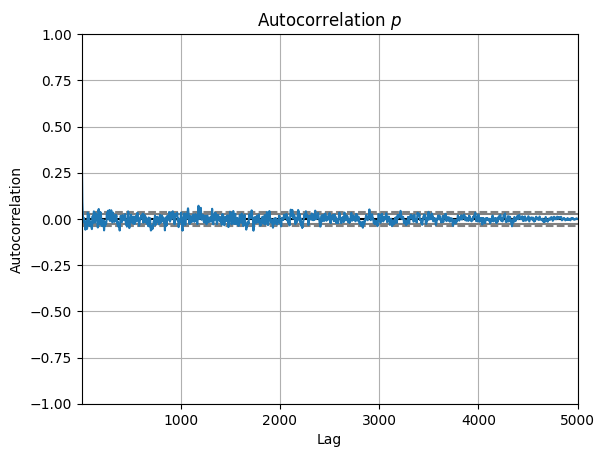

In [11]:
import pandas as pd

ps_0 = [sample[0] for sample in posterior_samples_0]
plt.subplot()
plt.title("Autocorrelation $p$")
pd.plotting.autocorrelation_plot(ps_0)